In [32]:
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline

# Grid Search
モデルのパラメータに対して最良の値を設定する一般的な方法に、総当たりで組み合わせを試すのがグリッドサーチがある

SVMで重要なパラメータに、gamma(カーネルバンド幅)、C（正則化パラメータ）がある。  
gammaとCに6つのパラメータを設定すると、考えられる組み合わせは6*6の36通りある。ナイーブにforを用いて総当たりしたのちGridSearchを試す

In [2]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print('Size of training set: {} size of test set: {}'.format(X_train.shape[0], X_test.shape[0]))

Size of training set: 112 size of test set: 38


In [3]:
best_score = 0
for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in  [0.001,0.01,0.1,1,10,100]:
        #それぞれのパラメータの組合せでSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        #評価
        score = svm.score(X_test,y_test)
        #良いスコアならスコアとパラメータを更新
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
            
print('Best score :{:,.2f}'.format(best_score))
print('Best paramters: {}'.format(best_parameters))

Best score :0.97
Best paramters: {'C': 100, 'gamma': 0.001}


これを見ると、このデータセットに対して97%の精度をもつモデルを見つけたと言うは楽観的すぎる(もしくは間違っている)  
**それはテストデータに対する予測が最も良いものでパラメータのチューニングを使ってしまったので、全くの未知のデータセットにこのパラメータが適しているとは言えないからである。**  
これを回避するに最も一般的な方法は、訓練データとテストデータを分けたように、訓練データ(train set)、チューニング用の検証または開発データ(validation set)、テストデータ(test set)、と3分割する方法である。

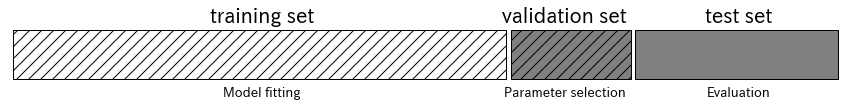

In [4]:
mglearn.plots.plot_threefold_split()

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
#訓練セットを訓練セットと検証セットに分割する
X_train, X_valid, y_train, y_valid  = train_test_split(X_trainval,y_trainval,random_state=1)
print('Size of training set: {} size of validation set: {} size of test set: {}\n'.format(X_train.shape[0],X_valid.shape[0], X_test.shape[0]))

Size of training set: 84 size of validation set: 28 size of test set: 38



In [6]:
best_score = 0
for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in  [0.001,0.01,0.1,1,10,100]:
        #それぞれのパラメータの組合せでSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        #評価
        #score = svm.score(X_test,y_test)
        score = svm.score(X_valid,y_valid)
        #良いスコアならスコアとパラメータを更新
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
 

#訓練セットと検証セットを用いて、モデルを再構築し、テストセットで評価
svm = SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score = svm.score(X_test, y_test)
print('Best score on validation set :{:,.2f}'.format(best_score))
print('Best paramters: {}'.format(best_parameters))
print('Test set score with best parameters: {:.2f}'.format(test_score))

Best score on validation set :0.96
Best paramters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


検証セットに対するベストスコアは96%で先ほどよりすこし低下している(訓練セットをさらに分割したのでサンプル数が減った影響だろう)  
テストセットに対するスコア、つまり汎化性能を示すスコアは92%となった。**完全に未知なデータに対する性能として主張できるのは(パラメータを最良にチューニングした結果)97%ではなく92%ということになる**

Best paramters:が{'C': 10, 'gamma': 0.001}と{'C': 100, 'gamma': 0.001}の2つ結果が得られた。パラメータはデータセットの分割の方法に影響を受けるからである。これを解決するには訓練セットと検証セットの分割を1度だけ行うのではなく、それぞれのパラメータの組合せに対して交差検証を行うとよい

In [7]:
best_score = 0
for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in  [0.001,0.01,0.1,1,10,100]:
        #それぞれのパラメータの組合せでSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        #評価
        #score = svm.score(X_test,y_test)
        
        #score = svm.score(X_valid,y_valid)
        
        #現在のパラメータで得たモデルを用いて、訓練データでk分割交差検証を行う
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        #交差検証精度の平均をとる
        score = np.mean(scores)
        #良いスコアならスコアとパラメータを更新
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
 

#訓練セットと検証セットを用いて、モデルを再構築し、テストセットで評価
svm = SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score = svm.score(X_test, y_test)
print('Best score on validation set :{:,.2f}'.format(best_score))
print('Best paramters: {}'.format(best_parameters))
print('Test set score with best parameters: {:.2f}'.format(test_score))

Best score on validation set :0.97
Best paramters: {'C': 100, 'gamma': 0.01}
Test set score with best parameters: 0.97


/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnin

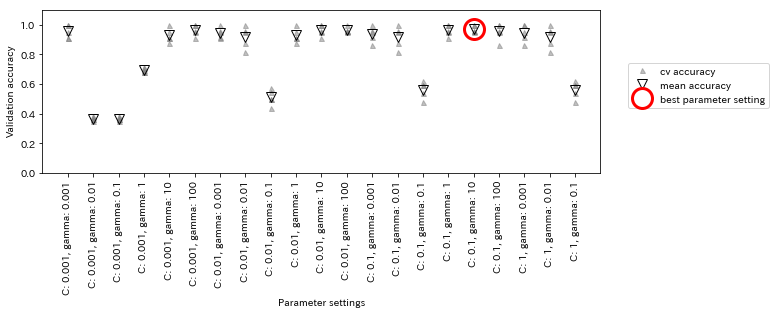

In [9]:
mglearn.plots.plot_cross_val_selection()

## GridSearchの一連の流れ
1. 個々のパラメータの組合せでモデルを構築
2. 構築したモデルを用いて、訓練データで交差検証を行う
3. 交差検証で得た精度を平均して、前回構築したモデルの精度を上回ったいたらパラメータを更新
4. 3.で得たベストなパラメータを用いて、モデルを再構築。
5. テストセットを用いて汎化性能を算出する

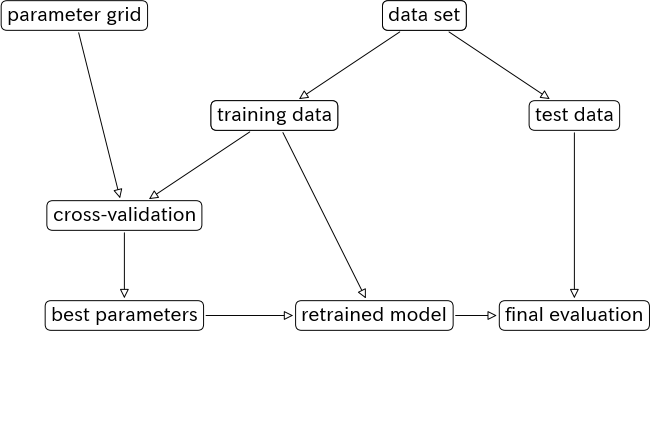

In [11]:
mglearn.plots.plot_grid_search_overview()

交差検証を用いたグリッドサーチは、非常に一般的にハイパーパラメータチューニングに使われるので、scikit-learnにはEstimatorの形でこの手法を実装したGridSearchCVクラスがある。

# GridSeachCV

In [12]:
#モデルに適用するハイパーパラメータの辞書型オブジェクトを作る
param_grid = {
    'C':[0.001,0.01,0.1,1,10,100],
    'gamma':[0.001,0.01,0.1,1,10,100]
             }
print('Parameter grid: {}'.format(param_grid))

Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [13]:
#GridSearchCVクラスに、使用するモデル、パラメーター、交差検証戦略を指定する
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

#パラメータの過剰適合を防ぐために訓練とテストセットにデータを分ける
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

grid_searchオブジェクトは通常のscikit-learn学習器のように振る舞う。つまり標準のfit、predict,scoreメソッドを呼ぶことができる。  
実際には、fitメソッドを呼ぶだけで、param_gridで指定したパラメータの組合せに対して交差検証が実行され、交差検証で最も性能がよかった最適なパラメータで訓練セット全体に対して新しいモデルを学習してくれる(まとめのモデルの再構築まで行う)。  
汎化性能が知りたければ、scoreメソッドを呼べばいい  
  
  
デフォルトでは回帰モデルはｋ分割交差検証、クラス分類では層化k分割検証を行うが、交差検証の分割器をcvパラメータに渡せば、独自の交差検証をおこなうことができる

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
print('Test set score: {:,.2f}'.format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [19]:
print('Best parameters: {}'.format(grid_search.best_params_))
#訓練セットに対する交差検証の平均精度の最もよかったとき
print('Best cross validation score: {:,.2f}'.format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross validation score: 0.97


In [20]:
#GridSearchCVにはpredict,scoreなどが実装されているのでわざわざbest_estimator属性にアクセスする必要はない
print('Best estimator: {}'.format(grid_search.best_estimator_))

Best estimator: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 交差検証の結果解析
グリッドサーチはパラメータの総当たりなので、計算コストがかかる。したがって、比較的に荒く小さなグリッドからはじめて結果をみてさらなるグリッドサーチを進めるかを段階的に踏んだほうがよい

In [33]:
result = pd.DataFrame(grid_search.cv_results_)
result.head()

/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnin

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001017,0.000148,0.000453,0.000111,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000887,0.000054,0.000374,0.000021,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000919,0.000092,0.000380,0.000021,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.000974,0.000124,0.000417,0.000097,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.001106,0.000192,0.000416,0.000092,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


In [28]:
#平均検証スコアを取り出し、軸がCとgammaとなるように変形する
#もともとは6×6のパラメータの組み合わせ
scores = np.array(result.mean_test_score).reshape(6,6)

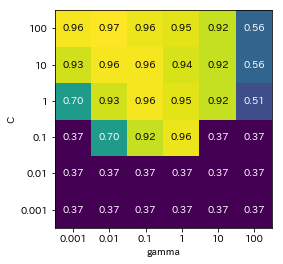

In [31]:
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

この図から見てわかるとおり、モデルがパラメータに非常に敏感である(精度が40%から90%までのレンジで存在する)。  

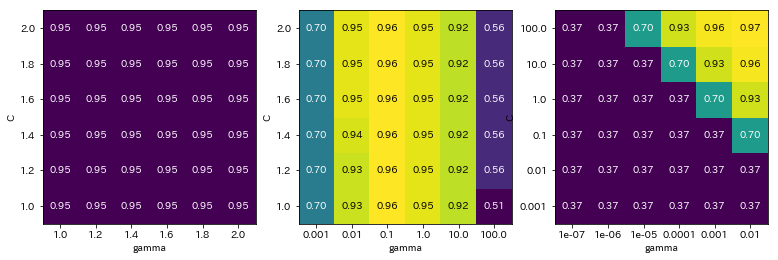

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(13,5))

param_grid_linear = {
    'C': np.linspace(1,2,6),
    'gamma':np.linspace(1,2,6)
                    }

param_one_log = {
    'C': np.linspace(1,2,6),
    'gamma':np.logspace(-3,2,6)
                    }

param_grid_range = {
    'C': np.logspace(-3,2,6),
    'gamma':np.logspace(-7,-2,6)
                    }

for param_grid, ax in zip([param_grid_linear, param_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    
    grid_search.fit(X_train, y_train)
    scores_image = np.array(grid_search.cv_results_['mean_test_score']).reshape(6,6)
    
    mglearn.tools.heatmap(scores_image, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap='viridis', ax=ax)
    
#plt.colorbar(scores_image,ax=axes.tolist())

- 最初のヒートマップではスコアに全く変化がない。これはパラメータのレンジが不適切か、そのパラメータが重要ではないかのどちらかだ
- 真ん中のヒートマップは横方向ににストライプのパターンが現れている。この場合はgammaのパラメータレンジが適切だが、Cのレンジは適切ではない。またはCのパラメータが重要ではないかのどちらかだ
- 右端のヒートマップは右上にスコアの改善が見られる。つまりこのレンジより先に最適なパラメータが存在する可能性もあるということだ

SVCにはkernelというパラメータがあり、これの指定で使用されるパラメーターが異なる。GridSearchCVはディクショナリーのリスト型を引数に取れるので、リストの中の個々のディクショナリが独立したグリッドに展開されて検証される

In [47]:
param_grid = [
    {'kernel':['rbf'],
     'C':[0.001,0.01,0.1,1,10,100],
     'gamma':[0.001,0.01,0.1,1,10,100]
    },
    {'kernel':['linear'],
     'C':[0.001,0.01,0.1,1,10,100],
    }
]

print('List of grid: \n{}'.format(param_grid))

List of grid: 
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


最初のグリッドではkernelはrbfになりCとgammaの36の組合せが実行され、次のグリッドではkenelがlinearでCの6つのパラメータが実行される

In [50]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best parameter: {}'.format(grid_search.best_params_))
print('Best cross-validation score : {:.2f}'.format(grid_search.best_score_))

Best parameter: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score : 0.97


## ネストした交差検証
先に示した例ではデータを訓練セット、検証セット、テストセットに分割し、さらに訓練セットで学習器を構築して、検証セットでパラメーターのチューニングを行い、最終的にテストセットで汎化性能をみた。GridSearchCVではデータを訓練セットとテストセットに一度だけ分けるので、この一度の分割に結果が依存していまいモデルが不安定になる可能性がある。  
ここではこれを一歩先にすすめて、元のデータを訓練とテストに一度だけ分けるのではなく交差検証で分割してハイパーパラメータチューニングした結果で再度交差検証を行う手法(ネストした交差検証)を考える。

In [57]:
param_grid = {
    'C':[0.001,0.01,0.1,1,10,100],
    'gamma':[0.001,0.01,0.1,1,10,100]
             }

scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)

print('Cross-validation scores: ' ,scores)
print('Mean corss-validation socre: ', scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean corss-validation socre:  0.9800000000000001


単純ループで書くと理解できるだろう

In [78]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

def nested_cv(X, y, inner_cv, outer_cv, Classifier, paramter_gird):
    outer_scores = []
    #splitメソッドはインデックスを返す
    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = -np.inf
        
        for parameters in paramter_gird:
            #{'C': 0.001, 'gamma': 0.001},{'C': 0.001, 'gamma': 0.01}...
            #ここのパラメータの組合せに対してループ(36通り)
            cv_scores = []
            
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                #パラメータチューニングに対する交差検証
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                #現在のパラメーターでモデルを評価
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            
            #内部分割によるスコアの平均を算出
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                #平均スコアがよければスコアとパラメータを更新
                best_score = mean_score
                best_params = parameters
            
        #最良のパラメータを用いて交差検証を行う
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        #評価する
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    
    return np.array(outer_scores)

In [79]:
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print('Cross-validation scores: {}'.format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


グリッドサーチと交差検証は計算コストがかかるが、個々のグリッドサーチパラメーターは互いに独立なので並列実行可能である。  
scikit-learnではn_jobsで並列実行をサポートしている。ただしネストした並列実行はサポートされていないので、ランダムフォレストのようにモデルで並列実行を指定しているとGridSearchCVで並列実行はできない